# Multiple linear regression

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import scipy.linalg as sp_la

## Data

Today we will keep working with the set of Craigslist listings for used cars.

In addition to the numeric columns odometer, year and price, I want to load the non-numeric columns manufacturer, model, condition, title_status, transmission and drive.

Because our numpy arrays all have to be the same type, we need to:
* figure out which columns we want
* define some converters

In [5]:
# these will be our columns
columns = ["price", "year", "manufacturer", "model", "condition", "fuel", "odometer", "title_status", "transmission"]
# this will contain our converters
colValues = {}

# first we load our data as strings so we can define the converters
data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), skip_header=1, dtype=str, encoding='utf-8'))  

# make a list of the unique values in each column of our data
for colIndex in range(data.shape[1]):
    colValues[colIndex] = np.unique(data[:, colIndex]).tolist()
    print(colIndex, colValues[colIndex])

# map values to their indices in the list of unique values
def converter(x, colIndex):
    return colValues[colIndex].index(x)

0 ['0', '1', '1000', '10000', '10199', '10200', '10300', '10399', '10400', '10450', '10475', '10488', '10491', '10494', '10495', '10498', '10500', '10550', '10600', '10650', '10691', '10695', '10700', '10800', '10844', '10888', '10900', '10950', '10977', '10980', '10988', '10989', '10990', '10995', '10999', '11000', '11011', '11200', '11250', '11272', '11375', '11380', '11450', '11480', '11493', '11495', '11499', '1150', '11500', '11515', '11550', '11600', '11700', '11795', '11900', '11901', '1195', '11950', '11976', '11985', '11987', '11988', '11990', '11995', '11997', '11999', '1200', '12000', '12177', '12250', '12400', '12450', '12488', '12495', '12499', '1250', '12500', '12588', '12595', '1275', '12775', '12835', '12875', '12889', '12900', '1295', '12950', '12977', '12990', '12995', '12999', '1300', '13000', '13299', '13300', '13325', '13400', '13440', '13450', '13488', '13490', '13494', '13495', '13500', '13599', '13600', '13650', '13750', '13753', '13795', '13850', '13860', '1388

Now we actually load the data.

In [6]:
# This dataset is the mazda subsample from https://www.kaggle.com/austinreese/craigslist-carstrucks-data after some cleanup

data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), converters={3: lambda x: converter(x, 2), 4: lambda x: converter(x, 3), 5: lambda x: converter(x, 4), 7: lambda x: converter(x,5), 9: lambda x: converter(x, 7), 11: lambda x: converter(x, 8)}, skip_header=1, dtype=int, encoding='utf-8'))  

Let's get some summary statistics and do a **pairplot** so we can see what's going on.

In [7]:
def getSummaryStatistics(data):
    print("min, max, mean, std per variable")
    return pd.DataFrame([data.min(axis=0), data.max(axis=0), data.mean(axis=0), data.std(axis=0)])

def getShapeType(data):
    print("shape")
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
print(getShapeType(data))

min, max, mean, std per variable
              0            1         2           3         4         5  \
0      0.000000  1999.000000  0.000000    0.000000  0.000000  0.000000   
1  55000.000000  2021.000000  1.000000  340.000000  5.000000  4.000000   
2   7978.281507  2012.381887  0.445535  159.225142  1.061431  2.012350   
3   5542.906703     3.997048  0.497025   96.160745  1.225660  0.138432   

              6         7         8  
0  0.000000e+00  0.000000  0.000000  
1  9.999999e+06  5.000000  2.000000  
2  1.124405e+05  0.209943  0.886954  
3  2.546163e+05  0.910812  0.424340  
shape
((3158, 9), dtype('int64'))


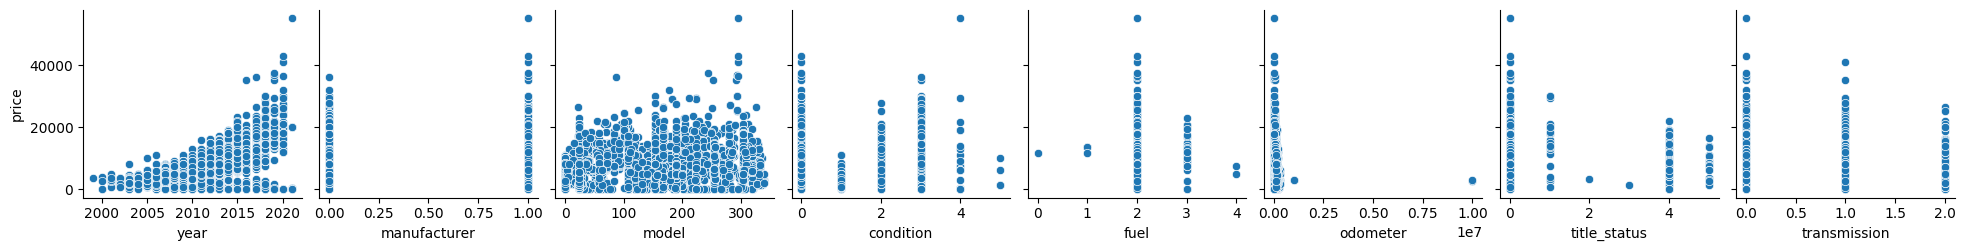

In [8]:
df = pd.DataFrame(data, columns=columns)
seaborn.pairplot(df, y_vars = columns[0], x_vars = columns[1:])

plt.show()

It looks like which variables might be correlated with price?

Let's calculate *correlations* between price and the other variables. (Remind me what correlation values vary between?)

In [9]:
for i in range(len(columns)):
    print(columns[i], np.corrcoef(data[:, 0], data[:, i], rowvar=True)[0,1])

price 1.0
year 0.5607406077976831
manufacturer 0.018020904958063123
model 0.12473024847425893
condition -0.01203518209383884
fuel 0.032451877318551946
odometer -0.1272187764664638
title_status 0.0023381200685889886
transmission -0.14757003596193927


## Let's review regression

Regression allows us to:
* determine the *nature* of a relationship between one (or more!) independent variables and a dependent variable
* determine the *strength* of the relationship

Regression *fits* a function to a dataset.

## What kinds of functions can we fit? 

I want to predict price as a function of age and mileage! After all, an old car with low mileage may be worth more than a new car with high mileage. Actually, I probably want to include some of those other variables (features) too! (Which ones?)

It turns out I can do this using **multiple linear regression**. The function I will want to fit will be: $\hat{y} = c_0 + c_1*x_{1i} + c_2*x_{2i} + ... + c_M*x_{Mi}$ for $M$ variables, and I do this by minimizing the sum of the squares of the residuals $r_i = y_i - \hat{y_i}$.

In terms of matrix math, for $N$
 data points, $A$
 will just be a matrix of shape ($N, M+1$)
 (including the leading column of 1s) and $\vec{c}$ 
 will have shape ($M+1, 1$)
 (including $c_0$, the intercept) and $\vec{y}$ will have shape ($N, 1$) (as before).

Let's do it! 

### First, split our data

Let's split our data into **train** and **test**. Let's make sure and sort by time first, because we don't want to let the future predict the past.

In [10]:
data = data[data[:, 1].argsort()]
print(getSummaryStatistics(data))
print(getShapeType(data))

(train, test) = np.split(data, [int(len(data) / 10 * 8)])
print(train.shape, test.shape)

min, max, mean, std per variable
              0            1         2           3         4         5  \
0      0.000000  1999.000000  0.000000    0.000000  0.000000  0.000000   
1  55000.000000  2021.000000  1.000000  340.000000  5.000000  4.000000   
2   7978.281507  2012.381887  0.445535  159.225142  1.061431  2.012350   
3   5542.906703     3.997048  0.497025   96.160745  1.225660  0.138432   

              6         7         8  
0  0.000000e+00  0.000000  0.000000  
1  9.999999e+06  5.000000  2.000000  
2  1.124405e+05  0.209943  0.886954  
3  2.546163e+05  0.910812  0.424340  
shape
((3158, 9), dtype('int64'))
(2526, 9) (632, 9)


### Second, define an updated fit function that can handle multiple independent variables

In [11]:
def fit(data, independent, dependent):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))

    # This is the dependent variable 
    y = data[:, dependent]

    # This is the regression coefficients that were fit, plus some other results
    c, _, _, _ = sp_la.lstsq(A, y)
    return c

In [12]:
print(columns)

['price', 'year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission']


And fit to our training data.

In [13]:
c = fit(train, [1,2,3,4,5,6,7,8], 0)
print([columns[x] for x in [1,2,3,4,5,6,7,8]])
print(c)

['year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission']
[-1.37911973e+06  6.89126822e+02 -7.06495016e+02  4.22798074e+00
 -2.30385221e+02  2.99441211e+02 -1.99376249e-04 -1.93098037e+02
 -6.54174469e+02]


### Third, define an updated predict function that can handle multiple independent variables

In [14]:
def predict(data, independent, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]
 
    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))

    return np.dot(A, c)

And predict

In [15]:
yhat = predict(test, [1,2,3,4,5,6,7,8], c)

### Fourth, evaluate using $R^2$

In [16]:
# assume these are numpy arrays
def rsquared(y, yhat):
    if len(y) != len(yhat):
        print("Need y and yhat to be the same length!")
        return 0
    return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

def plotxyyhat(x, y, yhat):
    plt.plot(x, y, 'o', label='data')
    plt.plot(x, yhat, label='least squares fit, $y = mx + b$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.show()

0.0744952305543074


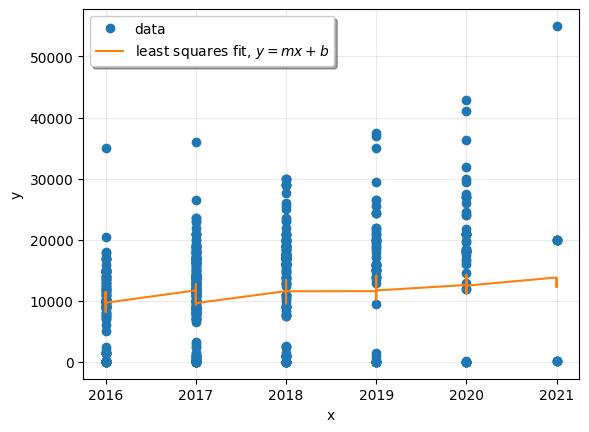

In [17]:
print(rsquared(test[:, 0], yhat))
# using only one independent variable to plot
plotxyyhat(test[:, 1], test[:, 0], yhat)


# Which model is best?

We can do **feature selection**. Here we do additive feature selection:
* repeatedly add an independent variable, train, and report $R^2$

We could also do a variant of additive feature selection using the correlations:
* sort independent variables by size of correlation (positive or negative!) with the dependent variable
* repeatedly add the independent variable with the next biggest correlation; if it leads to higher $R^2$, keep it; if it doesn't, drop it again

And we could also go from most features to fewest:
* start with a model fit using *all* independent variables
* repeatedly take an independent variable out; if the resulting model has higher $R^2$, leave that variable out going forward

There are many other options for feature selection!

In this code block, I calculate the *powerset* of all the independent variables. Then, for each subset of the independent variables I train a model and calculate MSSE (on the training data) and $R^2$ (on the test data). Then, I report the ten worst and ten best performing sets of independent variables by MSSE and by $R^2$.

Note:
* sometimes models with fewer variables work better than models with more
* sometimes a model may fit the training data better but the test data worse

In [39]:
from itertools import chain, combinations

def powerset(variables):
    return chain.from_iterable(combinations(variables, r) for r in range(len(variables)+1))

def msse(y, yhat):
    r = (np.square(y - yhat)).mean()
    return r

res = {}
for variableset in powerset(range(1, train.shape[1])):
    # fit the multiple linear regression
    c = fit(train, variableset, 0)
    # calculate MSSE and R^2
    res[variableset] = (msse(train[:, 0], predict(train, variableset, c)), rsquared(test[:, 0], predict(test, variableset, c)))

Worst R^2
['condition', 'title_status'] (15211296.544404062, -0.4964000155751995)
['condition'] (15211321.646852423, -0.4963724979743127)
['manufacturer', 'condition', 'title_status'] (15201513.897818033, -0.49539346691543185)
['manufacturer', 'condition'] (15201566.966245783, -0.49535374480358363)
['condition', 'fuel', 'title_status'] (15188261.59156966, -0.4948729878520213)
['condition', 'fuel'] (15188266.239887554, -0.49486214645873283)
['manufacturer', 'condition', 'fuel', 'title_status'] (15178436.708145147, -0.4938264758780828)
['manufacturer', 'condition', 'fuel'] (15178456.361570425, -0.4938043769802132)
['model', 'condition'] (14984766.339250393, -0.48009792728167233)
['model', 'condition', 'title_status'] (14984760.500376571, -0.4800834925167301)
Best R^2
['year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission'] (9957611.985568574, 0.08288045821969303)
['year', 'manufacturer', 'model', 'odometer', 'title_status', 'transmission'] (9958789.564901272,

In [42]:
# sort by R^2
byrsquared = sorted(res.items(), key=lambda item: item[1][1])
print("Worst R^2")
for i in range(10):
    print([columns[x] for x in byrsquared[i][0]], byrsquared[i][1])
print("Best R^2")
for i in range(1, 11):
    print([columns[x] for x in byrsquared[-i][0]], byrsquared[-i][1])

Worst R^2
['condition', 'title_status'] (15211296.544404062, -0.4964000155751995)
['condition'] (15211321.646852423, -0.4963724979743127)
['manufacturer', 'condition', 'title_status'] (15201513.897818033, -0.49539346691543185)
['manufacturer', 'condition'] (15201566.966245783, -0.49535374480358363)
['condition', 'fuel', 'title_status'] (15188261.59156966, -0.4948729878520213)
['condition', 'fuel'] (15188266.239887554, -0.49486214645873283)
['manufacturer', 'condition', 'fuel', 'title_status'] (15178436.708145147, -0.4938264758780828)
['manufacturer', 'condition', 'fuel'] (15178456.361570425, -0.4938043769802132)
['model', 'condition'] (14984766.339250393, -0.48009792728167233)
['model', 'condition', 'title_status'] (14984760.500376571, -0.4800834925167301)
Best R^2
['year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission'] (9957611.985568574, 0.08288045821969303)
['year', 'manufacturer', 'model', 'odometer', 'title_status', 'transmission'] (9958789.564901272,

In [41]:
# sort by MSSE
bymsse = sorted(res.items(), key=lambda item: item[1][0])
print("Worst MSSE")
for i in range(1, 11):
    print([columns[x] for x in bymsse[-i][0]], bymsse[-i][1])
print("Best MSSE")
for i in range(10):
    print([columns[x] for x in bymsse[i][0]], bymsse[i][1])


Worst MSSE
[] (15491585.905428203, -0.4563453050769968)
['title_status'] (15490773.48852736, -0.4566104441823169)
['manufacturer'] (15478394.370107492, -0.45591547214432837)
['manufacturer', 'title_status'] (15477433.752722148, -0.45620703283637654)
['fuel'] (15467706.814807473, -0.45491813192019626)
['fuel', 'title_status'] (15467052.968144245, -0.4551435061159472)
['manufacturer', 'fuel'] (15454455.509147257, -0.45444387624757776)
['manufacturer', 'fuel', 'title_status'] (15453667.976129238, -0.4546940700095641)
['transmission'] (15404220.702603156, -0.43130319865822164)
['title_status', 'transmission'] (15404208.09991579, -0.4313583067267319)
Best MSSE
['year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission'] (9888315.302769473, 0.0744952305543074)
['year', 'manufacturer', 'model', 'condition', 'odometer', 'title_status', 'transmission'] (9889577.65953909, 0.07446755749056166)
['year', 'manufacturer', 'model', 'condition', 'fuel', 'title_stat